In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
import os
current_path = ''
sys_path = os.path.join(prefix, current_path)
sys.path.append(sys_path)


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

#lib for display
from IPython.display import HTML, display, clear_output
try:
    plt.rcParams["animation.html"] = "jshtml"
except ValueError:
    plt.rcParams["animation.html"] = "html5"
    
#lib for loading mat datafile format
from scipy.io import loadmat

# plot in colab (on a web page)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#### K-means Clustering ####

# func1: Computes the centroid memberships for every example.
def find_closest_centroids(X, centroids):
    # Set K
    K = centroids.shape[0]
   
    #init
    idx = []

    #check - loop X (Samples)
    for x in X:
      #calculate dist. - loop centroids
      dist_comp = 10000
      min_cent_idx = 0
      for k_idx in range(centroids.shape[0]):
        k = centroids[k_idx,:]
        dist = np.sum((x - k)**2) + 2.225e-308
        if dist < dist_comp: 
          dist_comp = dist
          min_cent_idx = k_idx
        else: 
          pass
      #store min_idx
      idx.append(min_cent_idx)

    return idx

# func2: Returns the new centroids by computing the means of the data points assigned to each centroid.
def compute_centroids(X, idx, K):

    # Useful variables
    m, n = X.shape
    
    centroids = np.zeros((K, n))
    
    #reshpae i: m*1 --> m*k (0 or 1)
    i_new = np.zeros((m,K))
    for i in range (m):
      cluster = idx[i]
      i_new[i][cluster] = 1
    
    #count freq - by cluster
    cnt_by_cluster = np.sum(i_new,0) # 1 * k

    #get sum - by cluster
    sum_by_cluster = np.dot(X.T, i_new) # X'(n*m) , i_new (m*k) ==> n*k
    avg_by_cluster =sum_by_cluster /cnt_by_cluster
    
    centroids = avg_by_cluster.T
    
    return centroids

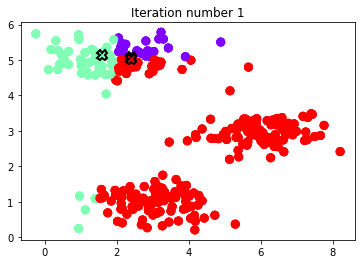

In [0]:
### TASK1: Data Classification ###

# Load an example dataset
data = loadmat(os.path.join(prefix, current_path, 'Data', 'ex7data2.mat'))
X = data['X']

# Settings for running K-Means
K = 3
max_iters = 10

# set centroids to specific values (they are random examples)
# initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
rand_idx = np.random.permutation(X.shape[0])
initial_centroids = X [rand_idx[:3],:]

# Run K-Means algorithm and plot the progress of K-Means
from utils import run_kmeans
centroids, idx, anim = run_kmeans(X, initial_centroids,
                                  find_closest_centroids, 
                                  compute_centroids, max_iters, True)
anim

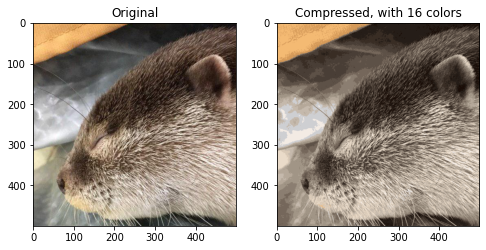

In [0]:
### TASK2: Image Data Compression & Recovery ###

K = 16
max_iters = 10

# Load an image
A = mpl.image.imread(os.path.join(prefix, current_path, 'Data', 'small_clawed_otter.png'))

# Reshape the image into an Nx3(Red, Green and Blue) matrix where N = number of pixels.
X = A.reshape(-1, 3)

# randomly initialize centroids
rand_idx = np.random.permutation(X.shape[0])
initial_centroids = X [rand_idx[:K],:]

# Run K-Means
centroids, idx = run_kmeans(X, initial_centroids,
                                 find_closest_centroids,
                                 compute_centroids,
                                 max_iters)

# recover the image from the indices (idx) by mapping each pixel
X_recovered = centroids[idx, :].reshape(A.shape)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255 and convert it back to uint8 image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)


In [0]:
### PCA ###

# func 1: Run principal component analysis
def pca(X):
    m, n = X.shape
    U = np.zeros(n)
    S = np.zeros(n)

    # X ==> U, S, V
    Sigma = (1/m) * np.dot(X.T, X)
    U, S, V = np.linalg.svd(Sigma)
    return U, S

# func 2: Computes the reduced data representation when projecting only on to the top K eigenvectors.
def project_data(X, U, K):
    Ureduce = U[:, :K] # n * K
    Z = np.dot(X,Ureduce)
    return Z

# func 3: Recovers an approximation of the original data when using the projected data.
def recover_data(Z, U, K):
    Ureduce = U[:, :K] # n * K  
    X_rec = np.dot(Z, Ureduce.T) #m*n = Z:m*k * Ureduce: n*K
    return X_rec


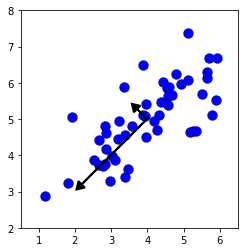

In [0]:
### TASK3: PCA - Simple PCA examples   ###

# Load the dataset into the variable X 
data = loadmat(os.path.join(prefix, current_path, 'Data', 'ex7data1.mat'))
X = data['X']

#  normalize X
from utils import feature_normalize
X_norm, mu, sigma = feature_normalize(X)

#  Run PCA
U, S = pca(X_norm)

### TASK3: PCA - Get eigen vectors   ###
#  Draw the eigenvectors centered at mean of data
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

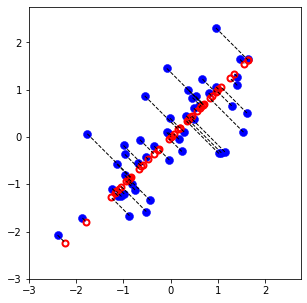

In [0]:
### TASK3: PCA - Project & Recovery   ###
#  Project the data onto K = 1 dimension
K = 1
Z = project_data(X_norm, U, K)

# Recovery
X_rec  = recover_data(Z, U, K)

#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)
plt.axis([-3, 2.75, -3, 2.75])

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

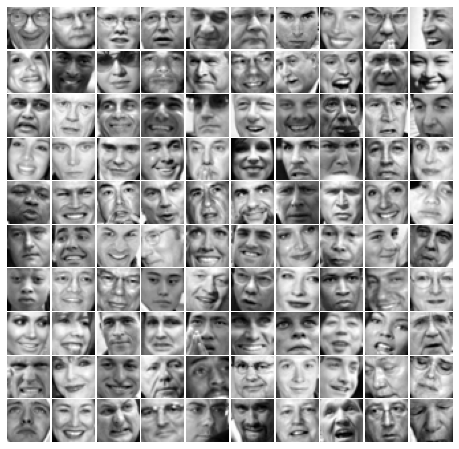

In [0]:
### TASK4: PCA - Image (Face images) Dimension Deduction   ###

#  Load Face dataset
data = loadmat(os.path.join(prefix, current_path, 'Data', 'ex7faces.mat'))
X = data['X']

#  Display the first 100 faces in the dataset
from utils import display_data
display_data(X[:100, :], figsize=(8, 8))

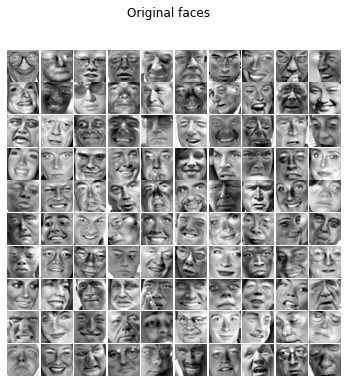

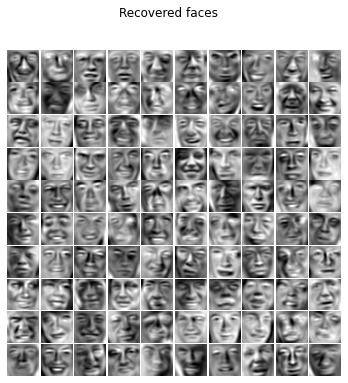

In [0]:
#  normalize X by subtracting the mean value from each feature
X_norm, mu, sigma = feature_normalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Visualize the top 36 eigenvectors found
# display_data(U[:, :36].T, figsize=(8, 8))

#  Project images to the eigen space using the top k eigenvectors 
K = 100
Z = project_data(X_norm, U, K)

#  Project images to the eigen space using the top K eigen vectors and visualize only using those K dimensions
K = 100
X_rec  = recover_data(Z, U, K)

# Display normalized data
display_data(X_norm[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
display_data(X_rec[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Recovered faces')
pass